# Project 11. Modelo de predicción de abandono clientes

### Descripción:
Los clientes de Beta Bank se están yendo, cada mes, poco a poco. Los banqueros descubrieron que es más barato salvar a los clientes existentes que atraer nuevos.

Necesitamos predecir si un cliente dejará el banco pronto. Tenemos los datos sobre el comportamiento pasado de los clientes y la terminación de contratos con el banco.

Crearemos un modelo con el máximo valor F1 posible. Para aprobar la revisión, necesitamos un valor F1 de al menos 0.59. Verificaremos F1 para el conjunto de prueba. 

Además, debes mediremos la métrica AUC-ROC y compararemos con el valor F1.

### Proceso:
Ya que nuestra intención es encontrar el mejor modelo, crearemos 3 modelos diferentes y probaremos cual de ellos tiene mejor desempeño, basados en la documentación sabemos que este nuestro modelo es de clasificación. Para esto, inicialmente importaremos las librerías que utilizaremos, cargaremos y preparararemos los datos. Nuestros datos serán divididos en 3 partes: Entrenamiento(60%), Validación(20%) y Prueba(20%). Posterior a esto verificaremos el equilibro de las clases, y entrenaremos nuestro modelo con nuestros datos sin trabajar en el desequilibrio de las clases y posteriormente trabajaremos en mejorar la calidad de nuestros modelos. Con nuestros nuevos datos mejorados entrenaremos nuevamente nuestros modelos y los pondremos a prueba con los datos de validación, finalmente aquel con mejores resultados en las métricas será el elegido para la prueba final con los datos de prueba. 

## Preparar datos:

### Inicializar

In [1]:
import re
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, precision_recall_curve, roc_curve, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from matplotlib import pyplot as plt

### Cargar datos

In [2]:
data = pd.read_csv('P11/churn.csv')

### Visualizar información de datos

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [4]:
print(data.head())

   RowNumber  CustomerId   Surname  CreditScore Geography  Gender  Age  \
0          1    15634602  Hargrave          619    France  Female   42   
1          2    15647311      Hill          608     Spain  Female   41   
2          3    15619304      Onio          502    France  Female   42   
3          4    15701354      Boni          699    France  Female   39   
4          5    15737888  Mitchell          850     Spain  Female   43   

   Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0     2.0       0.00              1          1               1   
1     1.0   83807.86              1          0               1   
2     8.0  159660.80              3          1               0   
3     1.0       0.00              2          0               0   
4     2.0  125510.82              1          1               1   

   EstimatedSalary  Exited  
0        101348.88       1  
1        112542.58       0  
2        113931.57       1  
3         93826.63       0  
4         790

In [5]:
print(data[data['Tenure'].isna()].head())

    RowNumber  CustomerId    Surname  CreditScore Geography  Gender  Age  \
30         31    15589475    Azikiwe          591     Spain  Female   39   
48         49    15766205        Yin          550   Germany    Male   38   
51         52    15768193  Trevisani          585   Germany    Male   36   
53         54    15702298   Parkhill          655   Germany    Male   41   
60         61    15651280     Hunter          742   Germany    Male   35   

    Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
30     NaN       0.00              3          1               0   
48     NaN  103391.38              1          0               1   
51     NaN  146050.97              2          0               0   
53     NaN  125561.97              1          0               0   
60     NaN  136857.00              1          0               0   

    EstimatedSalary  Exited  
30        140469.38       1  
48         90878.13       0  
51         86424.57       0  
53        164040.94 

### Preparación de datos

In [6]:
#Inicialmente convertiremos los nombres de las columnas a snake
import re
column_names = []
for name in data.columns:
    snaked_name1 = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', name)
    snaked_name2 = re.sub('([a-z])([A-Z])',  r'\1_\2', snaked_name1)
    lowered_name = snaked_name2.lower()
    column_names.append(lowered_name)
data.columns = column_names
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   row_number        10000 non-null  int64  
 1   customer_id       10000 non-null  int64  
 2   surname           10000 non-null  object 
 3   credit_score      10000 non-null  int64  
 4   geography         10000 non-null  object 
 5   gender            10000 non-null  object 
 6   age               10000 non-null  int64  
 7   tenure            9091 non-null   float64
 8   balance           10000 non-null  float64
 9   num_of_products   10000 non-null  int64  
 10  has_cr_card       10000 non-null  int64  
 11  is_active_member  10000 non-null  int64  
 12  estimated_salary  10000 non-null  float64
 13  exited            10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [7]:
#Verifiquemos duplicados
print(data.duplicated().sum())
print(data['customer_id'].duplicated().sum())

0
0


Ahora que sabemos que no hay duplicados, vemos que solo tenemos valores nulos en la columna 'tenure', de acuerdo a la información de data.info vemos que los valores nulos son casi el 10% de los valores de la columna así que eliminarlos sería una gran perdida de información.

In [8]:
#Veamos si hay algún patrón que relaciones las demás columnas con los valores nulos
print(data[data['tenure'].isna()].head(10))

     row_number  customer_id    surname  credit_score geography  gender  age  \
30           31     15589475    Azikiwe           591     Spain  Female   39   
48           49     15766205        Yin           550   Germany    Male   38   
51           52     15768193  Trevisani           585   Germany    Male   36   
53           54     15702298   Parkhill           655   Germany    Male   41   
60           61     15651280     Hunter           742   Germany    Male   35   
82           83     15641732      Mills           543    France  Female   36   
85           86     15805254    Ndukaku           652     Spain  Female   75   
94           95     15676966      Capon           730     Spain    Male   42   
99          100     15633059    Fanucci           413    France    Male   34   
111         112     15665790   Rowntree           538   Germany    Male   39   

     tenure    balance  num_of_products  has_cr_card  is_active_member  \
30      NaN       0.00                3      

In [9]:
#Veamos si hay alguín cambio en la media de clientes que abandonan el banco dependiendo de si existe o no el valore de tenure ya que el porcentaje de valores nulos es alto
tenure_missing_mean = data[data['tenure'].isna()]['exited'].mean()
tenure_not_missing_mean = data[data['tenure'].notna()]['exited'].mean()
print(tenure_missing_mean)
print(tenure_not_missing_mean)

0.20132013201320131
0.2039379606203938


Ya que parece que los valores nulos de la columna 'tenure' no tienen una influencia clara o relación directa importante en los clientes que se retiran del banco y ademas vemos tambien que estos clientes pueden tener tanto 1 como varios productos ademas de tarjeta de crédito y por tanto podemos asumir que no son nuevos clientes, reemplazaremos sus valores por los de la media o mediana.

In [10]:
#Veamos si hay una diferencia importante entre la media y la mediana
print(data['tenure'].mean())
print(data['tenure'].median())

4.997690023099769
5.0


In [11]:
#Ya que son practicamente iguales utilizaremos el el valor de la mediana que es cerrado
data['tenure'] = data['tenure'].fillna(data['tenure'].median())
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   row_number        10000 non-null  int64  
 1   customer_id       10000 non-null  int64  
 2   surname           10000 non-null  object 
 3   credit_score      10000 non-null  int64  
 4   geography         10000 non-null  object 
 5   gender            10000 non-null  object 
 6   age               10000 non-null  int64  
 7   tenure            10000 non-null  float64
 8   balance           10000 non-null  float64
 9   num_of_products   10000 non-null  int64  
 10  has_cr_card       10000 non-null  int64  
 11  is_active_member  10000 non-null  int64  
 12  estimated_salary  10000 non-null  float64
 13  exited            10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


Ahora que hemos corregido las columnas y los valores nulos, pasemos a los datos, los tipos de datos por ahora son correctos y no afectaran ninguno de nuestros modelos sin embargo, hay datos que no aportarán y que realmente no tienen ningún valor para el modelo, estos son 'row_number', 'customer_id', 'surname'. Ya que estas son características únicas de cada cliente, realmente no aportan valor que nos pueda indicar un comportamiento del mismo y por tanto no nos ayuda a predecir nada.

In [12]:
#Eliminamos las columnas de las que el modelo no obtendrá información para su predicción
customer_info = data[['row_number', 'customer_id', 'surname']].copy()
data = data.drop(['row_number', 'customer_id', 'surname'], axis=1)

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   credit_score      10000 non-null  int64  
 1   geography         10000 non-null  object 
 2   gender            10000 non-null  object 
 3   age               10000 non-null  int64  
 4   tenure            10000 non-null  float64
 5   balance           10000 non-null  float64
 6   num_of_products   10000 non-null  int64  
 7   has_cr_card       10000 non-null  int64  
 8   is_active_member  10000 non-null  int64  
 9   estimated_salary  10000 non-null  float64
 10  exited            10000 non-null  int64  
dtypes: float64(3), int64(6), object(2)
memory usage: 859.5+ KB


### Equilibrio de clases

In [14]:
#Veamos como se encuentra el equilibrio de las clases de nuestro objetivo: 'exited'
print(data['exited'].value_counts(normalize=True))

exited
0    0.7963
1    0.2037
Name: proportion, dtype: float64


Vemos que hay un desequilibrio de clases donde aproximadamente el 80% de las respuestas en nuestro objetivo son '0'.

### Entrenamiento modelos sin tener en cuenta el desequilibrio

In [15]:
#Antes que nada, codifiquemos nuestras características categóricas utilizando OHE
data_ohe = pd.get_dummies(data, dtype=int, drop_first=True)

In [16]:
#Separemos nuestros features y targets
features = data_ohe.drop(['exited'], axis=1)
target = data_ohe['exited']

In [17]:
#Separemos nuestros datos tanto para entrenamiento(60%), como para validación(20%) y prueba(20%)
features_train, features_valid_test, target_train, target_valid_test, customer_info_train, customer_info_valid_test = train_test_split(features, target, customer_info, test_size=0.4, random_state=12345)
features_valid, features_test, target_valid, target_test, customer_info_valid, customer_info_test = train_test_split(features_valid_test, target_valid_test, customer_info_valid_test, test_size=0.5, random_state=12345)

In [18]:
#Ahora codifiquemos nuestras características numéricas, siendo que 'is_active_member' es una característica binaria(0-1) puede no ser buena idea escalarla
#Por tanto mantendremos a 'is_active_member' como está, lo mismo aplicará para, 'has_cr_card':
numeric = ['credit_score', 'age', 'tenure', 'balance', 'num_of_products', 'estimated_salary']
features_train[numeric] = features_train[numeric].astype(float)
features_valid[numeric] = features_valid[numeric].astype(float)
features_test[numeric] = features_test[numeric].astype(float)

scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train.loc[:, numeric] = scaler.transform(features_train[numeric]) 
features_valid.loc[:, numeric] = scaler.transform(features_valid[numeric]) 
features_test.loc[:, numeric] = scaler.transform(features_test[numeric])

**Arbol de decisión**:

In [19]:
#Entrenemos y verifiquemos métricas en un modelo de árbol de decisión:
model = DecisionTreeClassifier(random_state=12345)
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)

print('Validation features:')
print('Accuracy:', accuracy_score(target_valid, predicted_valid))
print('Recall:', recall_score(target_valid, predicted_valid))
print('Precision:', precision_score(target_valid, predicted_valid))
print('F1:', f1_score(target_valid, predicted_valid))
print()

predicted_train = model.predict(features_train)
print('Training features:')
print('Accuracy:', accuracy_score(target_train, predicted_train))

Validation features:
Accuracy: 0.7935
Recall: 0.49521531100478466
Precision: 0.5061124694376528
F1: 0.5006045949214026

Training features:
Accuracy: 1.0


Hay un claro overfitting. Intentemos una prueba de cordura donde el valor de predicción es siempre 0:

In [20]:
#Prueba de cordura como valor de predicción = cero
predicted_valid = pd.Series(0, index=target_valid.index)
print('Accuracy:', accuracy_score(target_valid, predicted_valid))

Accuracy: 0.791


Claramente nuestro modelo no agrega ningún valor. Sigamos probando con otro tipo de modelos.

**Bosque aleatorio**

In [21]:
model = RandomForestClassifier(random_state=12345)
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)

print('Accuracy:', accuracy_score(target_valid, predicted_valid))
print('Recall:', recall_score(target_valid, predicted_valid))
print('Precision:', precision_score(target_valid, predicted_valid))
print('F1:', f1_score(target_valid, predicted_valid))

Accuracy: 0.8585
Recall: 0.46172248803827753
Precision: 0.7689243027888446
F1: 0.5769805680119582


**Regresión logística**

In [22]:
model = LogisticRegression(random_state=12345, solver='liblinear', class_weight='balanced')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)

print('Accuracy:', accuracy_score(target_valid, predicted_valid))
print('Recall:', recall_score(target_valid, predicted_valid))
print('Precision:', precision_score(target_valid, predicted_valid))
print('F1:', f1_score(target_valid, predicted_valid))

Accuracy: 0.702
Recall: 0.6818181818181818
Precision: 0.3810160427807487
F1: 0.4888507718696398


El ajuste del peso no cambio mucho los resultados.

## Mejora de modelos/Equilibrar clases
Ya que nuestra clase "1" es la que menos se repite pero es la más importante y nuestro objetivo, debemos trabajar en este equilibrio de clases utilizaremos dos enfoques: sobremuestreo y submuestreo.

### Sobremuestreo

In [23]:
#Hagamos una función que nos ayude a dividir nuestros datos de entrenamiento entre positivos(1) y negativos(0)
#Duplique los positivos varias veces ya que son los más importantes y posteriormente los una en un nuevo dataset
#Finalmente mezclaremos todos los datos, y entrenaremos nuevamente nuestros modelos

def upsample(features, target, repeat):
    #Dividamos los datos de entrenamiento:
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    #Dupliquemos varias veces las observaciones positivas y combinamos nuevamente
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)

    #Mezclemos nuestros datos
    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=12345)

    return features_upsampled, target_upsampled

#duplicaremos nuestros datos 'raros' en 3 para hacercarlos lo más posible a la cantidad de nuestros datos de clase 0
features_upsampled, target_upsampled = upsample(features_train, target_train, 3)
print(features_upsampled.head())
print(features_upsampled.shape)
print(target_upsampled.shape)

      credit_score       age    tenure   balance  num_of_products  \
4325     -0.886751  0.575842 -1.465685  1.299611        -0.891560   
778       1.055210 -1.037515 -0.009707 -1.233163         0.830152   
2580      0.463275 -0.088482  0.354288  0.901485        -0.891560   
109      -1.800614 -0.373192  1.446272  0.261412        -0.891560   
7689     -0.679054  0.670745  0.354288  0.196795        -0.891560   

      has_cr_card  is_active_member  estimated_salary  geography_Germany  \
4325            1                 0         -0.646058                  0   
778             1                 1         -0.811945                  0   
2580            1                 1         -1.595249                  1   
109             1                 0         -0.000819                  1   
7689            0                 0         -0.506978                  0   

      geography_Spain  gender_Male  
4325                1            0  
778                 0            1  
2580             

Ahora que tenemos nuestras clases equilibradas entrenemos nuevamente nuestros modelos.

**Ábol de decisión**

In [24]:
#Entrenemos y veamos que profundidad nos da mejor F1:
best_depth = 0
best_f1 = 0
for depth in range(1, 16, 1):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model.fit(features_upsampled, target_upsampled)
    predicted_valid = model.predict(features_valid)
    f1 = f1_score(target_valid, predicted_valid)
    if f1 > best_f1:
        best_f1 = f1
        best_depth = depth

print('F1:', best_f1)
print('Depth:', best_depth)

F1: 0.5863746958637469
Depth: 5


**Bosque aleatorio**

In [25]:
best_depth = 0
best_est = 0
best_f1 = 0
for est in range(10, 51, 10):
    for depth in range (1, 16, 1):
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)
        model.fit(features_upsampled, target_upsampled)
        predicted_valid = model.predict(features_valid)
        f1 = f1_score(target_valid, predicted_valid)
        if f1 > best_f1:
            best_f1 = f1
            best_est = est
            best_depth = depth

print('F1:', best_f1)
print('n_estimators:', best_est)
print('Depth:', best_depth)

F1: 0.6364692218350755
n_estimators: 40
Depth: 6


**Regresión logística**

In [26]:
model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)

print('F1:', f1_score(target_valid, predicted_valid))

F1: 0.5


Hemos encontrado que nuestro modelo con mejor calidad para el conjunto de datos de validación es el de bosque aleatorio con n_estimators=40 y max_depth=6. Intentemos ahora con Submuestreo.

### Submuestreo

In [27]:
#Hagamos una función que nos ayude a dividir nuestros datos de entrenamiento entre positivos(1) y negativos(0)
#Reduciremos la clase mayoritaria intentando alcanzar un balance
#Finalmente mezclaremos todos los datos, y entrenaremos nuevamente nuestros modelos
def downsample(features, target, fraction):
    #Dividir datos:
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    #reducir clase mayoritaria:
    features_downsampled = pd.concat([features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat([target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])

    #Mezclemos los datos
    features_downsampled, target_downsampled = shuffle(features_downsampled, target_downsampled, random_state=12345)
    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.3)
print(features_downsampled.head())
print(features_downsampled.shape)
print(target_downsampled.shape)

      credit_score       age    tenure   balance  num_of_products  \
2872     -2.216007  1.240166 -0.737696  0.315544         4.273576   
7748      1.969073 -0.373192  1.446272  0.697936        -0.891560   
1409     -2.164083  0.101325 -0.009707  0.124827        -0.891560   
1657      0.535969  1.429972  0.354288  0.918640         2.551864   
3623      0.442506 -1.132419 -0.009707  0.788171        -0.891560   

      has_cr_card  is_active_member  estimated_salary  geography_Germany  \
2872            1                 0          1.721125                  0   
7748            1                 0         -0.888108                  1   
1409            1                 0          0.767904                  0   
1657            1                 0          0.789303                  1   
3623            1                 0          0.100349                  1   

      geography_Spain  gender_Male  
2872                1            1  
7748                0            0  
1409             

Ahora que tenemos nuestras clases equilibradas entrenemos nuevamente nuestros modelos.

**Árbol de decisión**

In [28]:
#Entrenemos y veamos que profundidad nos da mejor F1:
best_depth = 0
best_f1 = 0
for depth in range(1, 16, 1):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model.fit(features_downsampled, target_downsampled)
    predicted_valid = model.predict(features_valid)
    f1 = f1_score(target_valid, predicted_valid)
    if f1 > best_f1:
        best_f1 = f1
        best_depth = depth

print('F1:', best_f1)
print('Depth:', best_depth)

F1: 0.579212916246216
Depth: 5


**Bosque aleatorio**

In [29]:
best_depth = 0
best_est = 0
best_f1 = 0
for est in range(10, 51, 10):
    for depth in range (1, 16, 1):
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)
        model.fit(features_downsampled, target_downsampled)
        predicted_valid = model.predict(features_valid)
        f1 = f1_score(target_valid, predicted_valid)
        if f1 > best_f1:
            best_f1 = f1
            best_est = est
            best_depth = depth

print('F1:', best_f1)
print('n_estimators:', best_est)
print('Depth:', best_depth)

F1: 0.6259220231822972
n_estimators: 40
Depth: 6


**Regresión logística**

In [30]:
model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(features_downsampled, target_downsampled)
predicted_valid = model.predict(features_valid)

print('F1:', f1_score(target_valid, predicted_valid))

F1: 0.497164461247637


En definitiva despues de evaluar nuestros modelos tanto con Sobremuestreo y Submuestreo, hemos encontrado el de mejores resultados, en nuestro caso el modelo de Bosque aleatorio con sobremuestreo con un F1: 0.63 que indica una captura razonable de resultados positivos y un balance aceptable del recall y precisión.

### Modelo Final

Antes de iniciar el entrenamiento de nuestro modelo final veamos como influye el umbral de clasificacion en el:

In [31]:
model = RandomForestClassifier(random_state=12345, n_estimators=40, max_depth=6)
model.fit(features_upsampled, target_upsampled)

#Busquemos la probabilidad de nuestro modelo de obtener 1
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid =  probabilities_valid[:, 1]

for threshold in np.arange(0, 1, 0.02):
    predicted_valid = (probabilities_one_valid >= threshold).astype('int')
    precision = precision_score(target_valid, predicted_valid)
    recall = recall_score(target_valid, predicted_valid)

    print('Threshold = {:.2f} | Precision = {:.3f}, Recall = {:.3f}'.format(threshold, precision, recall))


Threshold = 0.00 | Precision = 0.209, Recall = 1.000
Threshold = 0.02 | Precision = 0.209, Recall = 1.000
Threshold = 0.04 | Precision = 0.209, Recall = 1.000
Threshold = 0.06 | Precision = 0.209, Recall = 1.000
Threshold = 0.08 | Precision = 0.209, Recall = 1.000
Threshold = 0.10 | Precision = 0.215, Recall = 1.000
Threshold = 0.12 | Precision = 0.222, Recall = 0.995
Threshold = 0.14 | Precision = 0.235, Recall = 0.988
Threshold = 0.16 | Precision = 0.248, Recall = 0.981
Threshold = 0.18 | Precision = 0.257, Recall = 0.959
Threshold = 0.20 | Precision = 0.268, Recall = 0.940
Threshold = 0.22 | Precision = 0.286, Recall = 0.933
Threshold = 0.24 | Precision = 0.297, Recall = 0.923
Threshold = 0.26 | Precision = 0.316, Recall = 0.909
Threshold = 0.28 | Precision = 0.337, Recall = 0.890
Threshold = 0.30 | Precision = 0.360, Recall = 0.868
Threshold = 0.32 | Precision = 0.383, Recall = 0.856
Threshold = 0.34 | Precision = 0.404, Recall = 0.847
Threshold = 0.36 | Precision = 0.424, Recall =

C:\Users\javie\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\javie\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Claramente vemos que el threshold de 0.50 es un excelente valor y realiza predicciones muy buenas, sin embargo si se quisiera optimizar la detección de los clientes que se pueden ir aunque se detecten más falsos positivos, podriamos fijar el threshold en 0.40 - 0.45. Todo dependería de los costos que genere para el banco el trabajo de retención incluyendo los falsos positivos.

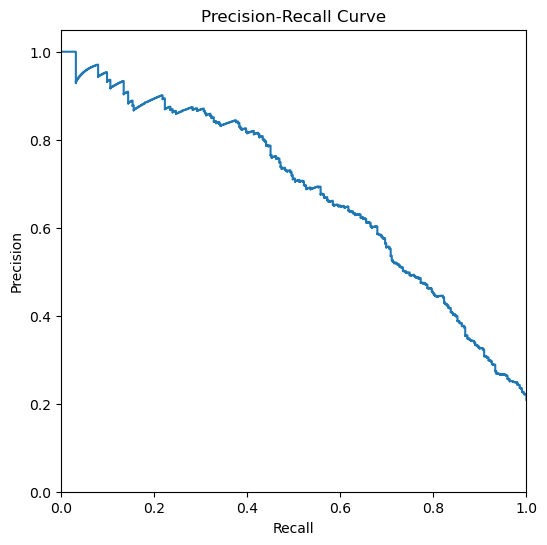

In [32]:
#Veamos la gráfica de la curva PR
precision, recall, thresholds = precision_recall_curve(
    target_valid, probabilities_valid[:, 1]
)

plt.figure(figsize=(6, 6))
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve')
plt.show()

Tenemos un buen modelo, equilibrado y nuestra curva lo demuestra.

Ahora entrenemos nuestro modelo final y realicemos una prueba final.

**Modelo Final**

In [33]:
#Antes debemos unir nuevamente nuestros datos de entrenamiento y validación
features_train_full = pd.concat([features_train, features_valid])
target_train_full = pd.concat([target_train, target_valid])
print(target_train_full.value_counts())

exited
0    6386
1    1614
Name: count, dtype: int64


In [34]:
#Balanceamos clases usando sobremuestreo, usemos la función que creamos anteriormente
features_upsampled_full, target_upsampled_full = upsample(features_train_full, target_train_full, 3)
print(features_upsampled_full.head())
print(features_upsampled_full.shape)
print(target_upsampled_full.shape)

      credit_score       age    tenure   balance  num_of_products  \
776      -0.315586  1.809586  0.718283  0.649221        -0.891560   
6027      2.052152  0.480939 -0.737696  1.027098         0.830152   
8449     -0.159814 -0.562998 -0.009707  0.600783        -0.891560   
1815     -1.478685 -0.657902  1.446272  0.430309        -0.891560   
9272      0.899437  0.291132 -1.101690  1.047210         0.830152   

      has_cr_card  is_active_member  estimated_salary  geography_Germany  \
776             1                 0          0.362289                  1   
6027            0                 1          1.503095                  1   
8449            0                 1         -0.591977                  0   
1815            1                 1         -0.924310                  0   
9272            1                 0          1.258277                  0   

      geography_Spain  gender_Male  
776                 0            0  
6027                0            1  
8449             

In [35]:
#Entrenemos nuestro modelo con nuestros datos completos
model = RandomForestClassifier(random_state=12345, n_estimators=40, max_depth=6)
model.fit(features_upsampled_full, target_upsampled_full)

#probemos nuestro modelo
predicted_test = model.predict(features_test)
print('F1 del modelo final:', f1_score(target_test, predicted_test))

F1 del modelo final: 0.586046511627907


In [36]:
#El F1 ha bajado al entrenar el modelo con los datos de train y valid juntos y probarlo con el conjunto de prueba
#Veamos si debemos modificar el umbral para encontrar el F1 optimo
probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]

best_f1 = 0
best_thr = 0
for thr in np.arange(0, 1, 0.01):
    predicted_test = (probabilities_one_test >= thr).astype('int')
    f1 = f1_score(target_test, predicted_test)
    if f1 > best_f1:
        best_f1 = f1
        best_thr = thr
print('F1 máximo:', best_f1)
print('Threshold optimo:', best_thr)

F1 máximo: 0.5984703632887189
Threshold optimo: 0.42


Hemos encontrado un modelo que cumple las expectativas, hemos obtenido un F1 de 0.59 con un umbral optimo de 0.42. 

Tal vez podamos mejorarlo un poco más:

**Prueba final**

In [37]:
#Intentemos mejorar nuestro modelo de Bosque buscando los mejores hiperparámetros y realizando una validación cruzada

rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [4, 6, 8, None],
    'min_samples_split': [2, 5, 10],
    'class_weight': [None, 'balanced']
}

rf_grid = GridSearchCV(
    estimator=RandomForestClassifier(random_state=12345),
    param_grid=rf_param_grid,
    scoring='f1',
    cv=5,
    n_jobs=-1
)

rf_grid.fit(features_upsampled_full, target_upsampled_full)

rf_best = rf_grid.best_estimator_
print("✔ Random Forest best params:", rf_grid.best_params_)


✔ Random Forest best params: {'class_weight': 'balanced', 'max_depth': None, 'min_samples_split': 2, 'n_estimators': 300}


In [38]:
#Entrenemos nuestro modelo con nuestros nuevos hiperparámetroc y nuestros datos completos
model = RandomForestClassifier(random_state=12345, class_weight='balanced', max_depth=None, min_samples_split=2, n_estimators=300)
model.fit(features_upsampled_full, target_upsampled_full)

predicted_test = model.predict(features_test)
print('F1:', f1_score(target_test, predicted_test))

F1: 0.601889338731444


In [39]:
#Encontremos el F1 máximo para este modelo
model = RandomForestClassifier(random_state=12345, class_weight='balanced', max_depth=None, min_samples_split=2, n_estimators=300)
model.fit(features_upsampled_full, target_upsampled_full)

probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]

best_f1 = 0
best_thr = 0
for thr in np.arange(0, 1, 0.01):
    predicted_test = (probabilities_one_test >= thr).astype('int')
    f1 = f1_score(target_test, predicted_test)
    if f1 > best_f1:
        best_f1 = f1
        best_thr = thr
print('F1 máximo:', best_f1)
print('Threshold optimo:', best_thr)

F1 máximo: 0.6194029850746269
Threshold optimo: 0.45


Finalmente este es nuestro mejor modelo sin necesidad de modificar el umbral hemos encontrado un modelo de Bosque aleatorio con n_estimators=100, max_depth=6 con un F1=0.60. Hemos obtenido estos valores ya que hemos aumentado el tamaño de nuestro bosque y esto hace mas fuerte nuestro modelo.

Igualmente se ha logrado aumentar el F1 a 0.61 modificando nuestro umbral a 0.47, el modelo es solido y tiene buenas métricas.

### Curva ROC

Veamos como se relacionan la Tasa de Verdaderos Positivos y la Tasa de Falsos Positivos:

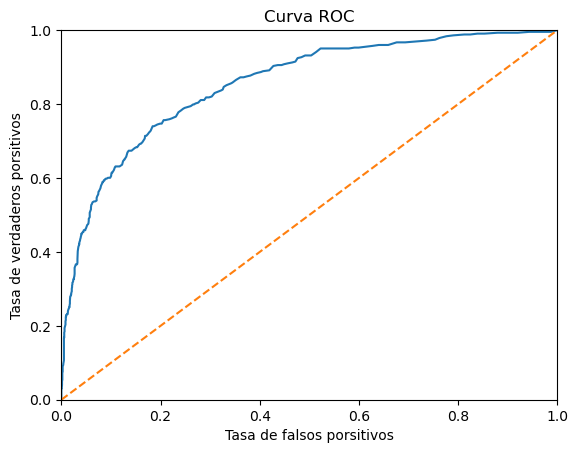

In [40]:
model = RandomForestClassifier(random_state=12345, class_weight='balanced', max_depth=None, min_samples_split=2, n_estimators=300)
model.fit(features_upsampled_full, target_upsampled_full)

probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]

fpr, tpr, treshold = roc_curve(target_test, probabilities_one_test)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Tasa de falsos porsitivos')
plt.ylabel('Tasa de verdaderos porsitivos')

plt.title('Curva ROC')
plt.show()

In [41]:
#Calculemos el área bajo la curva
print('AUC-ROC:', roc_auc_score(target_test, probabilities_one_test))

AUC-ROC: 0.8543633286411789


Vemos que nuestra tasa de verdaderos positivos es buena y la de falsos positivos es aceptable de nuestra gráfica. Sin embargo tambien tenemos que nuestro AUC: 0.85 nos indica que hay una alta probabilidad de que nuestro modelo asigne el valor adecuado a un cliente que se retiraría del banco pronto. 

### Predicción
Finalmente veamos que clientes están proximos a abandonar el banco. Para estos recomendamos al banco iniciar una campaña de retención, por nuestro valor de F1: 0.61 sabemos que detectaremos a la mayoría sin embargo tambien sabemos que habrá algunos falsos positivos, aún así, en general, es menos costoso contactar con clientes que no se irán que atraer nuevos clientes.

In [42]:
model = RandomForestClassifier(random_state=12345, class_weight='balanced', max_depth=None, min_samples_split=2, n_estimators=300)
model.fit(features_upsampled_full, target_upsampled_full)

predicted_test = model.predict(features_test)

results = customer_info_test.copy()
results['predicted_churn'] = predicted_test

print(results)
print(results[results['predicted_churn'] == 1])

      row_number  customer_id      surname  predicted_churn
7041        7042     15753591           He                0
5709        5710     15606158     Genovese                0
7117        7118     15765257         Meng                0
7775        7776     15731246       Hobler                0
8735        8736     15713599  Castiglione                0
...          ...          ...          ...              ...
9335        9336     15739123       Mellor                1
7999        8000     15591489      Davison                0
6139        6140     15806407       Wilson                0
9473        9474     15690733       Angelo                0
3366        3367     15684010         Tuan                0

[2000 rows x 4 columns]
      row_number  customer_id   surname  predicted_churn
6184        6185     15664339        Yu                1
8101        8102     15588955     Mazzi                1
9587        9588     15653050   Norriss                1
3168        3169     156807

Este modelo indica que de los 2000 clientes contenidos en el conjunto de prueba 318 abandonarán el banco pronto. Sin embargo nuestras métricas nos indican que de estos 318, aproximadamente el 61% realmente abandonarían el banco. Se recomienda al banco evaluar a estos usuarios e iniciar una campaña de retención si es posible.

### Conclusión

Para encontrar el mejor modelo realizamos una codificación de características categoricas usando OHE, y de características numéricas escalandolas, además debimos balancear nuestras clases objetivo usando sobremuestreo lo que al final nos permitió mejorar nuestro modelo de Bosque aleatório hasta encontrar un F1 de 0.63. Al realizar nuestra prueba final entrenando nuestro modelo con el conjunto de entrenamiento y validación, y utilizarlo para predecir utilizando el conjunto de prueba, nos arrojó un F1 de 0.58. Ya que este no es un valor de la métrica aceptable pudimos ver que aumentando el n_estimators a 100 nuestro F1 tambien aumentó hasta 0.60, siendo este nuestro mejor modelo sin ajustar el umbral. Este modelo final nos muestra que este modelo predice la mayoria de los clientes que se van, además obtuvimos un AUC de 0.85 lo que indica que hay una probabilidad de 85% de que nuestro modelo clasifique correctamente al usuario que se va.